In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot

%matplotlib inline

In [3]:
# no difference between .mat and .pkl
af = scipy.io.loadmat("dir_tune.mat")

In [4]:
direc = af["direction"]
spike_t = af["spikeTimes"]

In [16]:
zero_deg = spike_t[direc == 0]
print(zero_deg.shape)

(18,)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


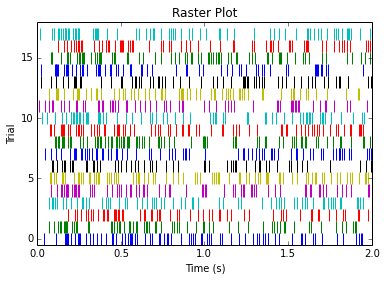

In [6]:
color_cycle = plt.rcParams['axes.color_cycle']

# plot the spike raster
for z_i, ze in enumerate(list(zero_deg)):
    color = [color_cycle[z_i % len(color_cycle)]]
    plt.eventplot(ze, colors=color, lineoffsets=[1*z_i])
plt.xlim(0, 2.0)
plt.ylim(-0.5, 1*zero_deg.shape[0])
plt.ylabel("Trial")
plt.xlabel("Time (s)")
plt.title("Raster Plot")
plt.savefig("spike-raster")

In [17]:
# hmmmmm... 5ms bins seems really small. Unless you want me to sum over all trials?
better_zd = []
for z_i in range(zero_deg.shape[0]):
    better_zd.append(zero_deg[z_i][0])
better_zd = np.array(better_zd)
print(better_zd.shape)

(18,)


In [8]:
# get the firing rate
bins = np.arange(0, 2.005, 0.005)
multi_trial_rate = np.zeros((bins.shape[0] - 1, better_zd.shape[0]))
for z_i in range(better_zd.shape[0]):
    multi_trial_rate[:, z_i] = np.histogram(better_zd[z_i], bins=bins)[0]

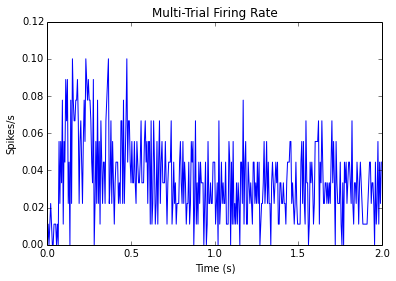

In [9]:
plt.plot(bins[:-1], np.mean(multi_trial_rate/5.0, axis=1))
plt.title("Multi-Trial Firing Rate")
plt.ylabel("Spikes/s")
plt.xlabel("Time (s)")
plt.savefig("multi-fr")

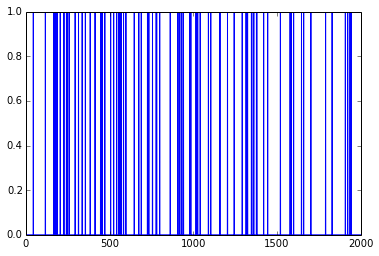

In [10]:
from scipy.ndimage.filters import gaussian_filter1d

trial = spike_t[0][8][0]
trial_t = np.arange(0, 2.001, 0.001)
sp_trial = np.zeros(trial_t.shape)
sp_trial[np.array(trial*1000, dtype=np.int64)] = 1
plt.plot(sp_trial)

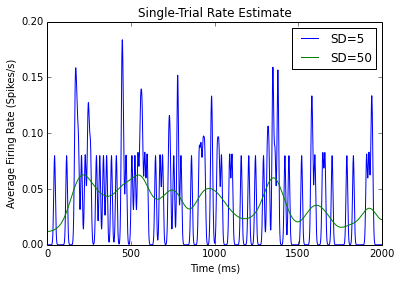

In [12]:
plt.plot(gaussian_filter1d(sp_trial, sigma=5))
plt.plot(gaussian_filter1d(sp_trial, sigma=50))
plt.title("Single-Trial Rate Estimate")
plt.xlabel("Time (ms)")
plt.ylabel("Average Firing Rate (Spikes/s)")
plt.legend(["SD=5", "SD=50"])
plt.savefig("gaussrate")

In [14]:
dirs = np.unique(direc)
d_spikes = [[] for _ in range(dirs.shape[0])]
n_spikes = [[] for _ in range(dirs.shape[0])]
spike_mean = [0.0 for _ in range(dirs.shape[0])]
spike_std = [0.0 for _ in range(dirs.shape[0])]

for d_i, d_val in enumerate(list(dirs)):
    # get the spikes for each trial
    tmp_spikes = spike_t[direc == d_val]
    
    # filter spikes to only take into account 50 to 250ms
    for t_s in range(tmp_spikes.shape[0]):
        tmp = tmp_spikes[t_s][0]
        tmp = tmp[np.where(tmp > 0.05)[0]]
        tmp = tmp[np.where(tmp < 0.25)[0]]
        d_spikes[d_i].append(tmp)
        n_spikes[d_i].append(tmp.shape[0])

        spike_mean[d_i] = np.mean(n_spikes[d_i])/(0.25-0.05)
        spike_std[d_i] = np.std(n_spikes[d_i])/(0.25-0.05)

d_spikes = np.array(d_spikes)
n_spikes = np.array(n_spikes)

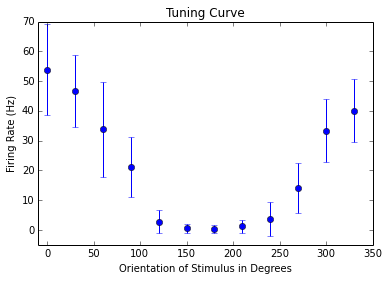

In [15]:
plt.errorbar(dirs, spike_mean, yerr=spike_std, fmt='o')
plt.xlim(-10, 350)
plt.ylim(-5, 70)
plt.title("Tuning Curve")
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Orientation of Stimulus in Degrees")
plt.savefig("tuningcurve")